## 1. Importing Libraries & Data Exploration

In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GlobalAveragePooling1D, MaxPooling1D, Conv1D, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [372]:
df_fake = pd.read_csv('data/Fake.csv.gz')

In [373]:
df_fake['fake'] = 1

In [374]:
len(df_fake)

23481

In [375]:
df_true = pd.read_csv('data/True.csv.gz')

In [376]:
df_true['fake'] = 0

In [377]:
len(df_true)

21417

Adding the binary 1/0 labels for fake/real news articles.

In [378]:
df_true_upsampled = resample(df_true, replace=True, n_samples=len(df_fake), random_state=42)

In [379]:
df = pd.concat([df_fake, df_true_upsampled], axis=0)

In [380]:
df = sklearn.utils.shuffle(df, random_state=42).reset_index(drop=True)

Upsampling the real news articles to counter the slight class imbalance that was present. The fake and real news dataframes were then concatenated and shuffled to get an even distribution of the classes throughout the dataframe.

In [381]:
len(df)

46962

In [382]:
df['fake'].value_counts(normalize=True)

1    0.5
0    0.5
Name: fake, dtype: float64

In [383]:
df.drop(columns=['text', 'subject', 'date'], inplace=True)
df.rename(columns={'title':'headline'}, inplace=True)

In [384]:
df.isnull().sum()

headline    0
fake        0
dtype: int64

In [385]:
df.to_csv('data/data_cleaned.csv')

We are only interested in predicting the validity of the news article from the headline alone, therefore I remove the 'text', 'subject' and 'date' columns. This dataframe is then saved as a csv to be loaded in for a later section.

In [386]:
df.head()

,headline,fake
0,NOT KIDDING! OBAMA Agrees To Turkey’s Demands…...,1
1,"Clinton, in book, says Trump's debate stalking...",0
2,BREAKING NEWS: Susan Rice ADMITS To Unmasking ...,1
3,China's interference in Hong Kong reaching ala...,0
4,WOW! FOX REPORTER GOES OFF On SEIU Thug For Te...,1


## 2. Preprocessing with NLTK

For the baseline model, NLP preprocessing is done with NLTK. This includes the following stages:

- Removing punctuation
- Tokenisation
- Removing stop words
- Part of speech tagging
- Lemmatisation
- Word vectorization
- TFIDF transformation

### 2.1. Removing Punctuation

In [387]:
df['headline'] = df['headline'].apply(lambda x: re.sub(r"\<.*\>", "", x))

In [388]:
punctuation = '''!()-[]{};:"\,<>./?@#$%^&*_~'''

In [389]:
def remove_punctuation(review):
    cleaned = "".join([char for char in review if char not in punctuation])
    return cleaned

In [390]:
df['headline'] = df['headline'].apply(lambda x: remove_punctuation(x))

In [391]:
df.head()

,headline,fake
0,NOT KIDDING OBAMA Agrees To Turkey’s Demands…U...,1
1,Clinton in book says Trump's debate stalking m...,0
2,BREAKING NEWS Susan Rice ADMITS To Unmasking “...,1
3,China's interference in Hong Kong reaching ala...,0
4,WOW FOX REPORTER GOES OFF On SEIU Thug For Tel...,1


### 2.2. Wordclouds

In [392]:
def remove_stopwords(review_tokenized):
    no_stop = [word.lower() for word in review_tokenized if word.lower() not in stop_words]
    return no_stop

In [393]:
def create_wordcloud(words, type):
    cloud = WordCloud(background_color="white", max_words=200, colormap="viridis", stopwords = set(STOPWORDS))
    cloud.generate(words)
    cloud.to_file(f"wordclouds/{type}_cloud.png")

In [394]:
df_fake = df.loc[df['fake'] == 1]

In [395]:
fake_words = []
for i, row in df_fake.iterrows():
    fake_words.append(row['headline'].lower())
fake_words = " ".join([fake_words[i] for i in range(len(fake_words))])

In [396]:
create_wordcloud(fake_words, "fake")

In [397]:
df_real = df.loc[df['fake'] == 0]

In [398]:
real_words = []
for i, row in df_real.iterrows():
    real_words.append(row['headline'].lower())
real_words = " ".join([real_words[i] for i in range(len(real_words))])

In [399]:
create_wordcloud(real_words, "real")

### 2.3. Tokenisation, Removing Stop Words, POS Tagging & Lemmatisation

In [400]:
lemmatizer = WordNetLemmatizer()

In [401]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [402]:
def remove_stopwords(headline_tokenized):
    no_stop = [word.lower() for word in headline_tokenized if word.lower() not in stop_words]
    return no_stop

In [403]:
def lemmatize_headline(review):
    tokenized = nltk.word_tokenize(review)
    no_stop = remove_stopwords(tokenized)
    nltk_tagged = nltk.pos_tag(no_stop)  
    wn_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wn_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [404]:
stop_words = stopwords.words("English")

In [405]:
df['headline'] = df['headline'].apply(lambda x: lemmatize_headline(x))

In [406]:
df.head()

,headline,fake
0,kid obama agree turkey ’ demands…us troop orde...,1
1,clinton book say trump 's debate stalking make...,0
2,break news susan rice admits unmask “ us perso...,1
3,china 's interference hong kong reach alarm le...,0
4,wow fox reporter go seiu thug tell black prote...,1


### 2.4. Vectorisation and TFIDF Transformation

In [407]:
vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(df['headline'].values)

In [408]:
tfidf_converter = TfidfTransformer()
X = tfidf_converter.fit_transform(X).toarray()

In [409]:
y = df.drop(columns='headline')

## 3. Modelling with Scikit-learn

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [46]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [301]:
params = {'penalty': ['l1', 'l2'], 'C': [0.01,0.1,1,10], 'solver':['newton-cg','lbfgs','liblinear','sag','saga']}

In [302]:
log_reg = LogisticRegression(random_state=42)

In [303]:
clf = GridSearchCV(log_reg, params, n_jobs=-1, cv=kfold)

In [304]:
clf.fit(X_train, y_train)

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
           

In [305]:
opt = pd.DataFrame(clf.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col or 'rank' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params, opt[cols]], axis=1)

In [306]:
opt.sort_values(by='rank_test_score', ascending=True).head(10)

,C,penalty,solver,mean_test_score,std_test_score,rank_test_score
6,0.01,l2,lbfgs,0.725669,0.004710,1
16,0.10,l2,lbfgs,0.725485,0.004851,2
26,1.00,l2,lbfgs,0.725196,0.004596,3
36,10.00,l2,lbfgs,0.725091,0.004770,4
28,1.00,l2,sag,0.724644,0.005598,5
8,0.01,l2,sag,0.724644,0.005598,5
38,10.00,l2,sag,0.724644,0.005598,5
18,0.10,l2,sag,0.724644,0.005598,5
19,0.10,l2,saga,0.724223,0.005883,9
34,10.00,l1,saga,0.724223,0.005883,9


Since there is very little difference in validation score between the various logistic regression configurations, the best performing from this grid search will be selected as the baseline model.

In [307]:
best_model = clf.best_estimator_
best_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [308]:
best_model.score(X_train, y_train)

0.7239076712760923

In [309]:
best_model.score(X_val, y_val)

0.7307783297847172

## 4. Preprocessing with Tensorflow

For the neural networks, NLP preprocessing is done with Tensorflow. This includes the following stages:

- Tokenisation
- Sequencing
- Padding

In [439]:
df2 = pd.read_csv('data/data_cleaned.csv')
df2.drop(columns='Unnamed: 0', inplace=True)

In [440]:
df2.head()

,headline,fake
0,NOT KIDDING! OBAMA Agrees To Turkey’s Demands…...,1
1,"Clinton, in book, says Trump's debate stalking...",0
2,BREAKING NEWS: Susan Rice ADMITS To Unmasking ...,1
3,China's interference in Hong Kong reaching ala...,0
4,WOW! FOX REPORTER GOES OFF On SEIU Thug For Te...,1


In [442]:
X_train, X_test, y_train, y_test = train_test_split(df2['headline'].values, df2['fake'].values, test_size=0.1)

In [443]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [444]:
tokenizer = Tokenizer(num_words=1500, oov_token='UNK')

In [445]:
tokenizer.fit_on_texts(X_train)

In [446]:
X_train = tokenizer.texts_to_sequences(X_train)

In [447]:
max_length = max([len(x) for x in X_train])
max_length

44

In [448]:
lengths = [len(x) for x in X_train]

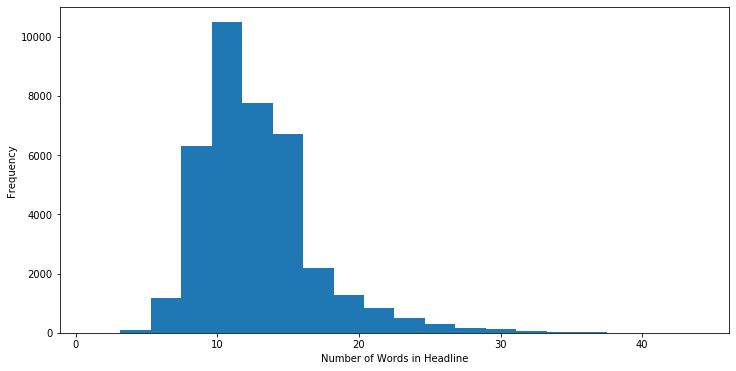

In [449]:
plt.figure(figsize=(12,6))
plt.hist(lengths, bins=20)
plt.xlabel('Number of Words in Headline')
plt.ylabel('Frequency')
plt.show()

In [450]:
X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=20)

We don't want the sequences to be too sparse, so the max length a sequence can be is 20 words long. This captures all words for the vast majority of  headlines in the training set.

In [451]:
with open('tokenizer_news.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saving the tokeniser so that it can be used in the Flask application.

In [452]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', truncating='post', maxlen=20)

In [453]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=20)

Tokenising and padding the validation and test datasets with the tokeniser fitted to the training dataset.

## 5. Modelling with Tensorflow/Keras

### 5.1. Dense Neural Network

In [538]:
dnn = Sequential()
dnn.add(Embedding(1500, 32, input_length=20))
dnn.add(GlobalAveragePooling1D())
dnn.add(Dense(32, activation = 'relu'))
dnn.add(Dropout(0.3))
dnn.add(Dense(16, activation = 'relu'))
dnn.add(Dropout(0.3))
dnn.add(Dense(8, activation = 'relu'))
dnn.add(Dropout(0.3))
dnn.add(Dense(1, activation = 'sigmoid'))
dnn.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 20, 32)            48000     
_________________________________________________________________
global_average_pooling1d_14  (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 8)               

In [539]:
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [540]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            mode='auto',
                                            restore_best_weights=True)

In [541]:
history1 = dnn.fit(X_train,
                  y_train,
                  epochs=10,
                  callbacks=[callback], 
                  validation_data=(X_val, y_val))

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38038 samples, validate on 4227 samples
Epoch 1/10
38038/38038 [==============================] - 7s 177us/step - loss: 0.2561 - accuracy: 0.9154 - val_loss: 0.1119 - val_accuracy: 0.9588
Epoch 2/10
38038/38038 [==============================] - 5s 143us/step - loss: 0.1311 - accuracy: 0.9634 - val_loss: 0.1051 - val_accuracy: 0.9617
Epoch 3/10
38038/38038 [==============================] - 5s 141us/step - loss: 0.1050 - accuracy: 0.9670 - val_loss: 0.1017 - val_accuracy: 0.9659
Epoch 4/10
38038/38038 [==============================] - 5s 140us/step - loss: 0.0935 - accuracy: 0.9686 - val_loss: 0.1080 - val_accuracy: 0.9669
Epoch 5/10
38038/38038 [==============================] - 5s 140us/step - loss: 0.0849 - accuracy: 0.9717 - val_loss: 0.1093 - val_accuracy: 0.9633


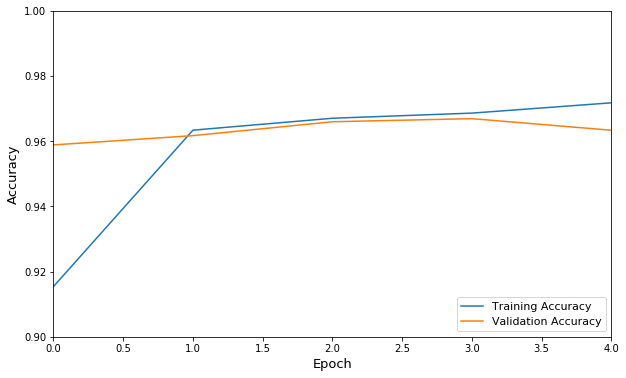

In [550]:
plt.figure(figsize=(10,6))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.xlim(0,4)
plt.ylim(0.90, 1)
plt.legend(loc='lower right', fontsize=11)
plt.show()

In [489]:
val_score = dnn.evaluate(X_val, y_val)

4227/4227 [==============================] - 0s 26us/step


In [490]:
print(f'Model val loss: {round(val_score[0], 3)} \nModel val accuracy: {round(val_score[1]*100, 2)}%')

Model val loss: 0.098 
Model val accuracy: 96.71%


In [491]:
test_score = dnn.evaluate(X_test, y_test)

4697/4697 [==============================] - 0s 26us/step


In [492]:
print(f'Model test loss: {round(test_score[0], 3)} \nModel test accuracy: {round(test_score[1]*100, 2)}%')

Model test loss: 0.097 
Model test accuracy: 96.66%


### 5.2. Convolutional Neural Network

In [508]:
cnn = Sequential()
cnn.add(Embedding(input_dim=1500, output_dim=32, input_length=20))
cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn.add(MaxPooling1D(2))
cnn.add(Dropout(0.3))
cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn.add(MaxPooling1D(2))
cnn.add(Dropout(0.3))
cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn.add(Flatten())
cnn.add(Dense(8, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 20, 32)            48000     
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 64)           

In [509]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [510]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            mode='auto',
                                            restore_best_weights=True)

In [511]:
history2 = cnn.fit(X_train,
                  y_train,
                  epochs=10,
                  callbacks=[callback], 
                  validation_data=(X_val, y_val))

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38038 samples, validate on 4227 samples
Epoch 1/10
38038/38038 [==============================] - 15s 388us/step - loss: 0.2264 - accuracy: 0.9277 - val_loss: 0.1089 - val_accuracy: 0.9607
Epoch 2/10
38038/38038 [==============================] - 13s 352us/step - loss: 0.1279 - accuracy: 0.9657 - val_loss: 0.0882 - val_accuracy: 0.9697
Epoch 3/10
38038/38038 [==============================] - 13s 349us/step - loss: 0.0989 - accuracy: 0.9716 - val_loss: 0.0892 - val_accuracy: 0.9702
Epoch 4/10
38038/38038 [==============================] - 13s 351us/step - loss: 0.0782 - accuracy: 0.9771 - val_loss: 0.0808 - val_accuracy: 0.9737
Epoch 5/10
38038/38038 [==============================] - 13s 347us/step - loss: 0.0621 - accuracy: 0.9817 - val_loss: 0.0832 - val_accuracy: 0.9759
Epoch 6/10
38038/38038 [==============================] - 13s 338us/step - loss: 0.0496 - accuracy: 0.9857 - val_loss: 0.1065 - val_accuracy: 0.9711


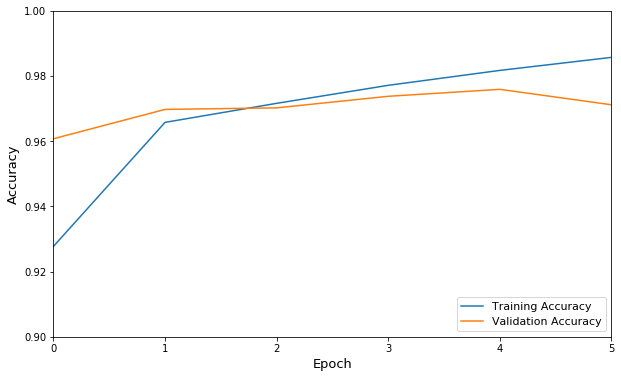

In [553]:
plt.figure(figsize=(10,6))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.xlim(0,5)
plt.ylim(0.90, 1)
plt.legend(loc='lower right', fontsize=11)
plt.show()

In [516]:
val_score = cnn.evaluate(X_val, y_val)

4227/4227 [==============================] - 0s 103us/step


In [517]:
print(f'Model val loss: {round(val_score[0], 3)} \nModel val accuracy: {round(val_score[1]*100, 2)}%')

Model val loss: 0.083 
Model val accuracy: 97.59%


In [518]:
test_score = cnn.evaluate(X_test, y_test)

4697/4697 [==============================] - 0s 104us/step


In [519]:
print(f'Model loss: {round(test_score[0], 3)} \nModel accuracy: {round(test_score[1]*100, 2)}%')

Model loss: 0.077 
Model accuracy: 97.64%


In [520]:
cnn.save("conv_net.h5")

In [530]:
def predict_review(model, sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, padding='post', truncating='post', maxlen=20)
    prediction = model.predict(sentence)
    probability = prediction[0][0]
    if prediction[0] > 0.5:
        print(f'This news article is FAKE! \nThe model is {np.round(probability * 100, 1)}% confident that this is the headline of a fake news article.')
    if prediction[0] < 0.5:
        print(f'This news article is REAL! \nThe model is {np.round((1-probability) * 100, 1)}% confident that this is the headline of a real news article.')
        

In [531]:
headline = "Fake news is real!"

In [532]:
predict_review(model, headline)

This news article is FAKE! 
The model is 96.5% confident that this is the headline of a fake news article.
